# Feature engineering

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 200)

In [4]:
df = pd.read_csv('Data/jobcloud_clean_v2.csv', sep=';', parse_dates=['start_dt', 'end_dt'])
df.head()

,id,start_dt,end_dt,1d_view_cnt,10d_view_cnt,30d_view_cnt,package_id,industry_name,job_location,job_postal_code,contract_pct_from,contract_pct_to,title,title_clean
0,8501672,2018-10-25,2018-11-26,0.2372,0.4565,0.7327,B,Industrie diverse,Espace Mittelland,NaN,100,100,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",softwarearchitekt projektmanager all one datenmanagement design produktion und qual
1,8501682,2018-10-25,2018-11-26,0.2883,0.5826,1.0991,B,Maschinen-/Anlagenbau,Region Biel,NaN,100,100,Prozessingenieur Lasertechnologie - Industrialisierung innovativer Fertigungstechnologien,prozessingenieur lasertechnologie industrialisierung innovativer fertigungstechnologien
2,8570830,2018-11-26,2018-12-28,0.1982,0.8468,1.1532,B,Industrie diverse,Espace Mittelland,NaN,100,100,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",softwarearchitekt projektmanager all one datenmanagement design produktion und qual
3,8649301,2019-01-08,2019-02-08,0.2883,0.7177,1.4835,B,Maschinen-/Anlagenbau,Espace Mittelland,NaN,100,100,Projektleiter (m/w) - Werkzeug- oder Maschinenbau,projektleiter werkzeug oder maschinenbau
4,8730602,2019-02-12,2019-02-21,0.3574,0.7297,0.7297,B,Industrie diverse,Region Biel,NaN,100,100,Fachverantwortlichen Metrologie - Produkteentwicklung und -validierung,fachverantwortlichen metrologie produkteentwicklung und validierung


## Clean titles
Regex online parser: https://regex101.com/

In [5]:
df['title_clean'] = df['title']

# Remove appended female form, e.g. FilialleiterIn => Filialleiter
df['title_clean'] = df['title_clean'].str.replace(r'\BIn\b', '')

# Convert all to lowercase
df['title_clean'] = df['title_clean'].str.lower()


# Match a single character not present in the list below [^\w&]
#  - \w match any word character in any script (equal to [\p{L}\p{N}_])
#  - & matches the character & literally (case sensitive)
df['title_clean'] = df['title_clean'].str.replace(r'[^\w&]', ' ')

# Remove numbers
df['title_clean'] = df['title_clean'].str.replace(r'[0-9]', '') 

# Remove specific words
df['title_clean'] = df['title_clean'].str.replace(r'(\bm\b|\bw\b|\bf\b|\br\b|\bin\b|\binnen\b|\bmw\b|\bdach\b|\bd\b|\be\b|\bi\b)', '')
# Special case M&A Spezialist: m is removed so &a is replaced by m&a
df['title_clean'] = df['title_clean'].str.replace(r'&a\b', 'm&a')

# Remove qualifications
df['title_clean'] = df['title_clean'].str.replace(r'(\bdipl\b|\bfachausweis\b|\babschluss\b|diplom|phd|msc|\buni\b|\bfh\b|\bfh\b|\beth\b|\btu\b)', '')

# Replace two or more consecutive spaces by only one space
df['title_clean'] = df['title_clean'].str.replace(r'[ ]{2,}', ' ')

# Remove spaces at the start and end
df['title_clean'] = df['title_clean'].str.strip()

df.loc[:, ['title', 'title_clean']].head(5)


,title,title_clean
0,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",softwarearchitekt projektmanager all one datenmanagement design produktion und qual
1,Prozessingenieur Lasertechnologie - Industrialisierung innovativer Fertigungstechnologien,prozessingenieur lasertechnologie industrialisierung innovativer fertigungstechnologien
2,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",softwarearchitekt projektmanager all one datenmanagement design produktion und qual
3,Projektleiter (m/w) - Werkzeug- oder Maschinenbau,projektleiter werkzeug oder maschinenbau
4,Fachverantwortlichen Metrologie - Produkteentwicklung und -validierung,fachverantwortlichen metrologie produkteentwicklung und validierung


## Date and contract percent
- Month of year
- Weekday
- Day of year (too many split points => overfitting)
- Days online (max = 30)
- Percentage range: contract_pct_to - contract_pct_from. A measure of "job flexibility".

In [6]:
df['month'] = df['start_dt'].dt.month_name()
df['weekday'] = df['start_dt'].dt.weekday_name
df['dayofyear'] = df['start_dt'].dt.dayofyear
df['days_online'] = (df['end_dt'] - df['start_dt']).dt.days
df['pct_range'] = df['contract_pct_to'] - df['contract_pct_from']

## City
- City: Define a list of top n city names and assign/extract from job_location. Anything that can't be assigned is assigned to an "other" category. This feature might explain a lot of variance in the view count.

In [7]:
city_mapping = {
    'Zürich': '(Zürich|Zurich|Zürcher)',
    'Bern': '(Bern|Berne)',
    'Basel': '(Basel|Bâle)',
    'Luzern': '(Luzern|Lucerne)',
    'Winterthur': 'Winterthur',
    'Zug': 'Zug',
    'Aarau': 'Aarau', 
    'St. Gallen': '(St. Gallen|Saint-Gall)',
#    'Solothurn': '(Solothurn|Soleure)', 
#    'Baden': 'Baden',
#    'Aargau': 'Aargau',
#    'Olten': 'Olten',
#    'Wallisellen': 'Wallisellen',
#    'Thun': 'Thun',
#    'Dietikon': 'Dietikon',
#    'Dübendorf': 'Dübendorf',
#    'Schaffhausen': 'Schaffhausen',
#    'Baar': 'Baar',
#    'Eschen': 'Eschen',
#    'Lausanne': 'Lausanne',
#    'Rotkreuz': 'Rotkreuz',
#    'Biel': '(Biel|Bienne)',
#    'Schlieren': 'Schlieren',
#    'Chur': 'Chur',
}

df['city'] = 'Other'
for city, pattern in city_mapping.items():
    mask = df['job_location'].str.contains(pattern)
    df.loc[mask, 'city'] = city
    
df['city'].value_counts()
    

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Other         50036
Zürich        24759
Bern           8158
Basel          6764
Luzern         3588
Zug            2646
Winterthur     2483
Aarau          1880
St. Gallen     1421
Name: city, dtype: int64

## Number of words in title
Are short or long titles better?

In [8]:
df['title_num_words'] = df['title'].str.split().str.len() # Not perfect, will count "a - b" as 3 words
df[['title', 'title_num_words']].head()

,title,title_num_words
0,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",12
1,Prozessingenieur Lasertechnologie - Industrialisierung innovativer Fertigungstechnologien,6
2,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",12
3,Projektleiter (m/w) - Werkzeug- oder Maschinenbau,6
4,Fachverantwortlichen Metrologie - Produkteentwicklung und -validierung,6


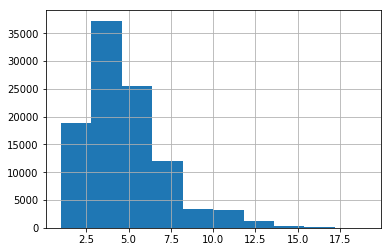

In [11]:
df['title_num_words'].hist();

## Aggression
Is aggressive: All uppercase, contains "!"

In [12]:
df['title_aggressive'] = (df['title'].str.isupper() | df['title'].str.contains('!'))
print(df['title_aggressive'].value_counts())
df.loc[df['title_aggressive'], ['title', 'title_aggressive']].head(10)

False    97752
True      3983
Name: title_aggressive, dtype: int64


,title,title_aggressive
421,LOGISTIKER / LAGER-SPEZIALIST,True
427,LOGISTIKER / LAGER-SPEZIALIST,True
431,LOGISTIKER / LAGER-SPEZIALIST,True
439,LOGISTIKER / LAGER-SPEZIALIST,True
558,PROJEKTLEITER ANLAGENBAU,True
913,TRADE FINANCE SPECIALIST,True
921,Zackige Assistentin 80-100% für ein regionales und familiäres KMU gesucht!,True
928,Wir suchen Produktionsmitarbeiter/innen mit Erfahrung!,True
932,Als Software Ingenieur Embedded Systems (m/w) sind neue Technologien Ihre Welt!,True
933,Kompetenter Immobilienbewirtschafter für eine Schweizer Familienunternehmung gesucht!,True


## Female gender explicitly named
"(m/w)", "(w/m)", "(m/f)", "(h/f)", "/ -in" , "/in", "(in)"? How to handle cases like "Rechtsanwältin/Rechtsanwalt", "Verantwortliche/-r Finanz- und Rechnungswesen (50-70 %)"?

In [13]:
# Problematic since English job titles are gender neutral, only relevant for German titles 
df['title_female'] = df['title'].str.contains(r'((m/w)|(w/m)|(m/f)|(h/f)|/ -in|/in|\(in\))', case=False)
print(df['title_female'].value_counts())
df[['title', 'title_female']].head(5)

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


True     52930
False    48805
Name: title_female, dtype: int64


,title,title_female
0,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",True
1,Prozessingenieur Lasertechnologie - Industrialisierung innovativer Fertigungstechnologien,False
2,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",True
3,Projektleiter (m/w) - Werkzeug- oder Maschinenbau,True
4,Fachverantwortlichen Metrologie - Produkteentwicklung und -validierung,False


## Contains contract percent
Search for "%" Should the contract percent range be (redundantly) stated in the job title or not?

In [18]:
df['title_percent'] = df['title'].str.contains('%')
print(df['title_percent'].value_counts())
df.loc[df['title_percent'], ['title', 'title_percent']].head(5)

False    62886
True     38849
Name: title_percent, dtype: int64


,title,title_percent
6,HR Business Partner (80-100%),True
8,Executive / Personal Assistant D/E 100%,True
21,Drug Safety und Medical Manager (80-100%),True
22,"M&A Spezialist (m/w), 100%",True
23,CEO Assistenz mit Drive 80-100 %,True


## Contains location ("Stadt" or "Region")

In [19]:
df['title_location'] = df['title'].str.contains(r'(\bRegion\b|\bBezirk\b|\bStadt\b|\bOrt\b)', case=False)
print(df['title_location'].value_counts())
df.loc[df['title_location'], ['title', 'title_location']].head(5)

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


False    100566
True       1169
Name: title_location, dtype: int64


,title,title_location
103,"Apotheker (Region ZH, BS oder BE)",True
394,Lehrmittelberater/-in für die Region Ostschweiz,True
752,Verkaufsberater Region Bern,True
783,Sales Executive Business Travel (Region Zürich),True
802,FilialleiterIn Reisebüro (Region Thurgau),True


## Mentions qualification 
"Dipl.", "PhD", "Master", etc..

In [20]:
df['title_diploma'] = df['title'].str.contains(r'(Dipl\.|\bFachausweis\b|\bAbschluss\b|Diplom|PhD|MSc|\bUni\b|\bFH\b|\bETH\b|\bTU\b)')
print(df['title_diploma'].value_counts())
df.loc[df['title_diploma'], ['title', 'title_diploma']].head(5)

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


False    97717
True      4018
Name: title_diploma, dtype: int64


,title,title_diploma
364,Treuhänder/in oder Buchhalter/in mit Fachausweis,True
366,Treuhänder/-in oder Buchhalter/-in mit Fachausweis,True
398,Entwicklungsingenieur FH o. ETH (m/w),True
412,Bauingenieur ETH/FH als Projektleiter (w/m),True
423,"Junger Elektronik-Ingenieur FH als ""SCADA-MASCHINENSTEUERUNGS ENGINEER"" 100% (w/m)",True


## Chief officer title (CxO) mentioned

In [21]:
df['title_chief'] = df['title'].str.contains(r'\bC.O\b')
print(df['title_chief'].value_counts())
df.loc[df['title_chief'], ['title', 'title_chief']].head(5)

False    101527
True        208
Name: title_chief, dtype: int64


,title,title_chief
7,Juniortalent als CEO-Assistenz,True
23,CEO Assistenz mit Drive 80-100 %,True
128,Strategische CEO Assistenz (m/w),True
143,Operations Manager - COO,True
148,CEO - Assistentin (100%),True


## Language detection

In [22]:
from langdetect import detect_langs
from langdetect import DetectorFactory 
DetectorFactory.seed = 0 # Deterministic results

# Initialize probablities with 0
languages = ['en', 'de', 'fr']
for lang in languages:
    df['title_prob_%s' % lang] = 0

for i, row in df.iterrows():
    lang_probs = detect_langs(row['title'])
    for lang_prob in lang_probs:
        for lang in languages:     
            if lang_prob.lang == lang:
                df.loc[i, 'title_prob_%s' % lang] = lang_prob.prob
                              
df[['title', 'title_prob_en', 'title_prob_de', 'title_prob_fr']].head()

,title,title_prob_en,title_prob_de,title_prob_fr
0,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",0.0,0.999994,0.0
1,Prozessingenieur Lasertechnologie - Industrialisierung innovativer Fertigungstechnologien,0.0,0.999996,0.0
2,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",0.0,0.999994,0.0
3,Projektleiter (m/w) - Werkzeug- oder Maschinenbau,0.0,0.999995,0.0
4,Fachverantwortlichen Metrologie - Produkteentwicklung und -validierung,0.0,0.999997,0.0


In [33]:
df['title_lang'] = 'none'
df['title_prob_max'] = df[['title_prob_de', 'title_prob_en', 'title_prob_fr']].max(axis=1)

df.loc[df['title_prob_de'] == df['title_prob_max'], 'title_lang'] = 'de'
df.loc[df['title_prob_en'] == df['title_prob_max'], 'title_lang'] = 'en'
df.loc[df['title_prob_fr'] == df['title_prob_max'], 'title_lang'] = 'fr'
df.loc[df['title_prob_max'] == 0, 'title_lang'] = 'none'
df.drop(columns='title_prob_max', inplace=True)

print(df['title_lang'].value_counts())
df.loc[df['title_lang'] != 'none', ['title', 'title_prob_en','title_prob_de','title_prob_fr', 'title_lang']].head(5)

de      72184
en      20933
none     5805
fr       2813
Name: title_lang, dtype: int64


,title,title_prob_en,title_prob_de,title_prob_fr,title_lang
0,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",0.0,0.999994,0.0,de
1,Prozessingenieur Lasertechnologie - Industrialisierung innovativer Fertigungstechnologien,0.0,0.999996,0.0,de
2,"Softwarearchitekt / Projektmanager (m/w) - All-in-One Datenmanagement in Design, Produktion und Qual",0.0,0.999994,0.0,de
3,Projektleiter (m/w) - Werkzeug- oder Maschinenbau,0.0,0.999995,0.0,de
4,Fachverantwortlichen Metrologie - Produkteentwicklung und -validierung,0.0,0.999997,0.0,de


## Is limited ("befristet")

In [34]:
df.loc[df['title'].str.contains('befristet'), :].shape

(662, 31)

## Are languages mentioned
e.g. (DE/FR), (DE/EN) => not enough examples

In [35]:
df.loc[df['title'].str.contains(r'\bDE\b') | df['title'].str.contains(r'\bFR\b') | df['title'].str.contains(r'\bEN\b'), ['title']].shape

(240, 1)

In [36]:
# Convert all bool columns to int
df.loc[:, df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)

In [37]:
## Save data with engineered features

In [38]:
df.to_csv('Data/jobcloud_features_v2.csv', sep=';', index=False)

## Feature correlations with viewcount

In [39]:
df = pd.read_csv('Data/jobcloud_features_v2.csv', sep=';', parse_dates=['start_dt', 'end_dt'])
df.head()

,id,start_dt,end_dt,1d_view_cnt,10d_view_cnt,30d_view_cnt,package_id,industry_name,job_location,job_postal_code,...,title_aggressive,title_female,title_percent,title_location,title_diploma,title_chief,title_prob_en,title_prob_de,title_prob_fr,title_lang
0,8501672,2018-10-25,2018-11-26,0.2372,0.4565,0.7327,B,Industrie diverse,Espace Mittelland,NaN,...,0,1,0,0,0,0,0.0,0.999994,0.0,de
1,8501682,2018-10-25,2018-11-26,0.2883,0.5826,1.0991,B,Maschinen-/Anlagenbau,Region Biel,NaN,...,0,0,0,0,0,0,0.0,0.999996,0.0,de
2,8570830,2018-11-26,2018-12-28,0.1982,0.8468,1.1532,B,Industrie diverse,Espace Mittelland,NaN,...,0,1,0,0,0,0,0.0,0.999994,0.0,de
3,8649301,2019-01-08,2019-02-08,0.2883,0.7177,1.4835,B,Maschinen-/Anlagenbau,Espace Mittelland,NaN,...,0,1,0,0,0,0,0.0,0.999995,0.0,de
4,8730602,2019-02-12,2019-02-21,0.3574,0.7297,0.7297,B,Industrie diverse,Region Biel,NaN,...,0,0,0,0,0,0,0.0,0.999997,0.0,de


In [40]:
corr = pd.get_dummies(df, columns=['package_id', 'city', 'industry_name', 'month']).corr(method='spearman').iloc[:, 1:4]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,1d_view_cnt,10d_view_cnt,30d_view_cnt
id,0.061,0.085,0.095
1d_view_cnt,1,0.91,0.82
10d_view_cnt,0.91,1,0.95
30d_view_cnt,0.82,0.95,1
contract_pct_from,-0.14,-0.15,-0.16
contract_pct_to,-0.15,-0.16,-0.16
dayofyear,-0.068,-0.057,-0.031
days_online,0.3,0.48,0.68
pct_range,0.077,0.085,0.094
title_num_words,0.02,0.032,0.026
